# Ohio H-2A visas analysis


### Import Python analysis tools

In [1]:
import os
import pandas as pd
import geopandas as gp
from datetime import date
from shapely.geometry import Point

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.options.display.max_columns = None

In [4]:
%matplotlib inline

In [5]:
input_dir = os.path.join(os.getcwd(), 'input')
output_dir = os.path.join(os.getcwd(), 'output')

### Prepare the data for analysis

Download the source data files from the U.S. Department of Labor's [Office of Foreign Labor Certification](https://www.foreignlaborcert.doleta.gov/performancedata.cfm).

In [6]:
%%capture
%run A_download.ipynb

Prepare them for analysis by carefully combining annual lists, winnowing out duplicate entries and limiting the result to approved applications.

In [7]:
%%capture
%run B_transform.ipynb

Map work site locations

In [8]:
%%capture
run C_geocode.ipynb

### Finding: The total number of certified H2A visas has generally increased nationwide

Read in the transformed file for analysis

In [9]:
df = pd.read_csv(
    os.path.join(output_dir, "transformed_master_cases.csv"),
    index_col="new_id",
)

Group by calendar year and sum the total number of certified workers

In [10]:
annual_usa = df.groupby("certification_start_year").agg(dict(workers_certified="sum"))

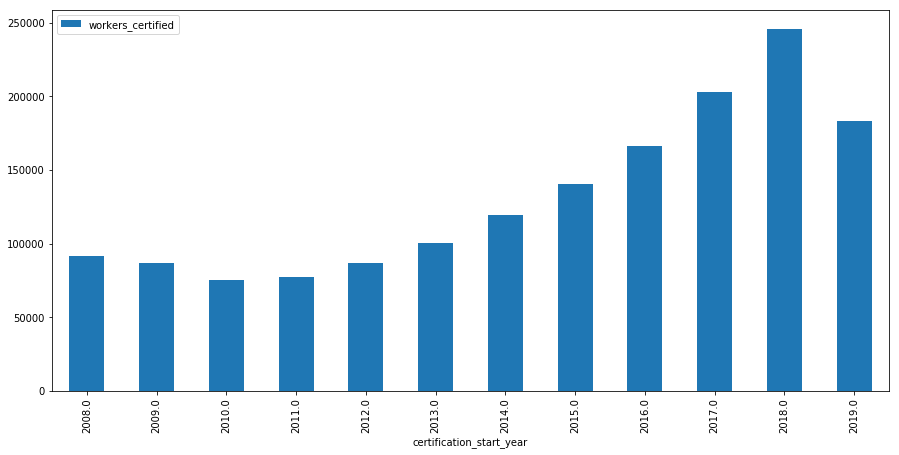

In [11]:
annual_usa.plot.bar(figsize=(15, 7))

In [12]:
annual_usa

,workers_certified
certification_start_year,
2008.0,91324
2009.0,86604
2010.0,75617
2011.0,77221
2012.0,86725
2013.0,100360
2014.0,119240
2015.0,140701
2016.0,166462


### Finding: The number of H-2A visas in Ohio spiked this year, following a steady increase between 2013 and 2018.

Group the applications by state and year

In [13]:
state_totals = df.groupby([
    'state',
    'certification_start_year']
).agg(dict(workers_certified="sum"))

Create a crosstab for a graphic and comparison

In [14]:
state_crosstab = state_totals.unstack(1).fillna(0)

Output it for a graphic

In [15]:
state_crosstab.to_csv("./output/state_crosstab.csv")

Filter down to just Ohio's totals

In [16]:
ohio_totals = state_totals[state_totals.index.get_level_values(0) == 'OH']

Ouput the annual totals

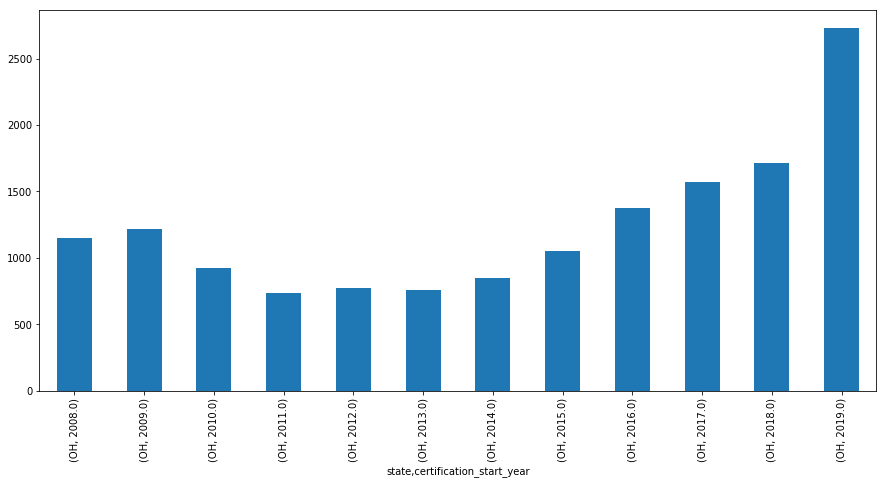

In [17]:
ohio_totals.workers_certified.plot.bar(figsize=(15, 7))

In [18]:
ohio_totals

workers_certified
state certification_start_year                   
OH    2008.0                                 1153
      2009.0                                 1216
      2010.0                                  924
      2011.0                                  733
      2012.0                                  770
      2013.0                                  762
      2014.0                                  845
      2015.0                                 1055
      2016.0                                 1375
      2017.0                                 1572
      2018.0                                 1713
      2019.0                                 2727

Trim down to the last five years of data and calculate Ohio's percentage change

In [19]:
ohio_last_five = ohio_totals[
    (ohio_totals.index.get_level_values(1) > 2013) &
    (ohio_totals.index.get_level_values(1) < 2019)
].reset_index()

In [20]:
ohio_pct_change = ohio_last_five[[
  'certification_start_year',
  'workers_certified'
]].set_index('certification_start_year').pct_change(
    len(ohio_last_five)-1
)

In [21]:
print ("Percent change: %s%%" % round(ohio_pct_change.at[2018.0, 'workers_certified']*100, 2))

Percent change: 102.72%


Output for a graphic

In [22]:
ohio_totals.reset_index()[['certification_start_year', 'workers_certified']].to_csv(
    "./output/ohio-totals-graphics.csv",
    index=False
)

### Finding: This year's hiring pace surpasses last year's rate.

Convert the start date column to a datetime object

In [23]:
df.certification_start_date = pd.to_datetime(df.certification_start_date)

Pull out the first eight months of this year versus last year

In [28]:
first_eight_19 = df[
    (df.state == 'OH') &
    (df.certification_start_date >= date(2019, 1, 1)) & 
    (df.certification_start_date < date(2019, 8, 1))
]

In [29]:
first_eight_18 = df[
    (df.state == 'OH') &
    (df.certification_start_date >= date(2018, 1, 1)) & 
    (df.certification_start_date < date(2018, 8, 1))
]

Compare the total hires in that period

In [30]:
first_eight_18.workers_certified.sum()

1428

In [31]:
first_eight_19.workers_certified.sum()

2678

### Finding: Northern Ohio counties are driving the growth

Read in all "sub" cases rather than the master cases. This allows for the farms where workers are actually employed to be mapped, rather than the the "master cases" of middlemen who sometimes file the "master" applications. 

In [32]:
combined_df = pd.read_csv(os.path.join(output_dir, "geocoded_all_cases.csv"))

Convert to a geodataframe.

In [33]:
def create_point(row):
    if row.lng and row.lat:
        return Point(row.lng, row.lat)
    return ''

In [34]:
combined_df['geometry'] = combined_df.apply(create_point, axis=1)

In [35]:
gdf = gp.GeoDataFrame(combined_df)

In [36]:
gdf.crs = {'init' :'epsg:4269'}

Exclude cases that could not be mapped.

In [37]:
valid_gdf = gdf[~gdf.lat.isnull()]

Spatial join with county polygons

In [38]:
counties = gp.read_file(os.path.join(input_dir, "cb_2016_us_county_5m.shp"))

In [39]:
gdf_with_county = gp.sjoin(counties, valid_gdf, how="inner")

In [42]:
gdf_with_county.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,index_right,case_number,case_status,certification_start_date,certification_start_year,city,crop,employer,fiscal_year,job_title,master_case,new_id,oregon_crop,row_number,state,sub_case,workers_certified,workers_subcases,net_workers,geocoder_address,lat,lng,geocoder_type
0,04,015,00025445,0500000US04015,04015,Mohave,06,34475567011,387344307,"POLYGON ((-114.755618 36.087166, -114.753638 3...",90069,C-11277-30159,Certified - Full,2011-12-10,2011.0,BEAVER DAM,Sheepherder,DAVID EARL/UPPER CREEK RANCH,2012,"FARMWORKERS, FARM AND RANCH ANIMALS",NaN,2012-221,Sheep,221,NV,True,2,0.0,2.0,"Beaver Dam, AZ 86432, USA",36.914262,-113.947699,APPROXIMATE
0,04,015,00025445,0500000US04015,04015,Mohave,06,34475567011,387344307,"POLYGON ((-114.755618 36.087166, -114.753638 3...",24545,H-300-13007-017676,Certified - Full,2013-02-28,2013.0,Mohave Valley,NaN,4-B FARMS,2013,Farm worker,False,2013-1781,NaN,1781,AZ,NaN,3,0.0,3.0,"Mohave Valley, AZ, United States",34.923840,-114.597862,bing
0,04,015,00025445,0500000US04015,04015,Mohave,06,34475567011,387344307,"POLYGON ((-114.755618 36.087166, -114.753638 3...",19897,C-12023-32079,Certified - Full,2012-03-08,2012.0,MOHAVE VALLEY,Alfalfa,4B FARMS,2012,FARMWORKER,False,2012-2559,Alfalfa,2559,AZ,NaN,3,0.0,3.0,"Mohave Valley, AZ, United States",34.923840,-114.597862,bing
0,04,015,00025445,0500000US04015,04015,Mohave,06,34475567011,387344307,"POLYGON ((-114.755618 36.087166, -114.753638 3...",25225,H-300-13023-165413,Certified - Full,2013-03-25,2013.0,Mohave Valley,NaN,DORAME FARMS INC.,2013,Farmworker,False,2013-2648,NaN,2648,AZ,NaN,4,0.0,4.0,"Mohave Valley, AZ, United States",34.923840,-114.597862,bing
1,12,035,00308547,0500000US12035,12035,Flagler,06,1257365642,221047161,"POLYGON ((-81.52365999999999 29.622432, -81.32...",38159,H-300-15236-295513,DETERMINATION ISSUED - CERTIFICATION,2015-10-02,2015.0,Bunnell,Vegetables (Verduras),Walter P. Rawl & Sons Inc,2015,Farmworker; Diversified,False,2015-4720,Vegetables (Verduras),4720,FL,NaN,24,0.0,24.0,"Bunnell, FL, USA",29.466086,-81.257842,APPROXIMATE


Filter to Ohio

In [43]:
ohio_gdf = gdf_with_county[gdf_with_county.STATEFP == '39']

Create a crosstab of the total number of workers by year in all Ohio counties

In [44]:
county_crosstab = ohio_gdf.groupby([
    'NAME',
    'certification_start_year'
]).net_workers.sum().reset_index().set_index([
    "NAME",
    "certification_start_year"
]).unstack(1).fillna(0)

Strip all the pandas chrome off the crosstab

In [45]:
county_crosstab = county_crosstab.reset_index()
county_crosstab.columns = county_crosstab.columns.droplevel(0)
county_crosstab = county_crosstab.rename_axis(None, axis=1)
county_crosstab = county_crosstab.set_index("")

Calculate the change in each county

In [46]:
county_crosstab['change_13to18'] = county_crosstab.apply(
    lambda x: x[2018.0] - x[2013.0],
    axis=1
)

Rank them by their change

In [47]:
county_crosstab.sort_values("change_13to18", ascending=False).head(10)

,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,change_13to18
,,,,,,,,,,,,,
Erie,340.0,20.0,20.0,26.0,25.0,25.0,29.0,32.0,32.0,146.0,178.0,48.0,153.0
Fulton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,72.0,78.0,80.0,70.0,80.0
Lake,225.0,257.0,292.0,201.0,240.0,202.0,181.0,65.0,271.0,292.0,264.0,271.0,62.0
Fayette,0.0,0.0,0.0,2.0,0.0,0.0,0.0,20.0,6.0,9.0,57.0,60.0,57.0
Seneca,0.0,0.0,0.0,0.0,0.0,0.0,42.0,43.0,181.0,48.0,49.0,47.0,49.0
Auglaize,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,47.0,47.0,2.0,47.0
Pickaway,3.0,4.0,4.0,14.0,24.0,24.0,31.0,47.0,87.0,61.0,71.0,73.0,47.0
Sandusky,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,32.0,37.0,40.0,40.0,40.0
Putnam,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,11.0,27.0,27.0,30.0,27.0


Output that for a graphic

In [48]:
county_crosstab.to_csv(os.path.join(output_dir, "county-crosstab.csv"), encoding="utf-8")

Total up the workers by city for a map

In [49]:
ohio_location_totals = ohio_gdf.groupby([
    "certification_start_year",
    "geocoder_address",
    "lat",
    'lng',
]).net_workers.sum().reset_index()

In [50]:
ohio_location_totals['certification_start_year'] = ohio_location_totals.certification_start_year.astype(int)

In [51]:
ohio_location_totals['net_workers'] = ohio_location_totals.net_workers.astype(int)

In [52]:
ohio_location_totals.columns = [
    'year',
    'address',
    'lat',
    'lng',
    'workers'
]

Output that for a graphic

In [53]:
ohio_location_totals.to_csv(os.path.join(output_dir, "ohio_totals_by_location.csv"), index=False)

### Finding: General Farm Laborers and fruit/vegetable farmworkers have accounted for most of the new workers in Ohio

Regroup subcases in the state by our cleaned up version of the crop column

In [54]:
ohio_crops = ohio_gdf.groupby([
    "certification_start_year",
    "oregon_crop"
]).net_workers.sum().reset_index().sort_values("net_workers", ascending=False)

Create a crosstab by year

In [55]:
crops_crosstab = ohio_crops.set_index([
    "certification_start_year",
    "oregon_crop"
]).unstack(0).fillna(0)

Again, strip the pandas chrome from the crosstab

In [56]:
crops_crosstab = crops_crosstab.reset_index()
crops_crosstab.columns = crops_crosstab.columns.droplevel(0)
crops_crosstab = crops_crosstab.rename_axis(None, axis=1)
crops_crosstab = crops_crosstab.set_index("")

Calculate the change over the past five years

In [61]:
crops_crosstab['change_15to19'] = crops_crosstab.apply(
    lambda x: x[2019.0] - x[2015.0],
    axis=1
)

Rank the crops

In [62]:
crops_crosstab.sort_values("change_15to19", ascending=False).head(10)

,2011.0,2012.0,2015.0,2016.0,2017.0,2018.0,2019.0,change_15to19
,,,,,,,,
General Farm Workers,0.0,0.0,0.0,0.0,65.0,125.0,161.0,161.0
Fruits and Vegetables,0.0,0.0,0.0,4.0,53.0,59.0,50.0,50.0
Tomatoes,0.0,0.0,28.0,61.0,141.0,234.0,76.0,48.0
Corn,2.0,2.0,0.0,5.0,8.0,2.0,21.0,21.0
Tobacco,0.0,0.0,0.0,18.0,25.0,10.0,15.0,15.0
Beans,0.0,0.0,0.0,21.0,0.0,0.0,10.0,10.0
Sod,4.0,0.0,0.0,6.0,3.0,5.0,6.0,6.0
Horses,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0
Agricultural Equipment Operators,0.0,0.0,2.0,14.0,0.0,15.0,6.0,4.0


Ouput for a graphic

In [63]:
crops_crosstab.to_csv(os.path.join(output_dir, "crops-crosstab.csv"))

### Looking at Erie County, OH

Filter down to subcases in this one county

In [64]:
erie = gdf_with_county[gdf_with_county.NAME.isin(['Huron', 'Sandusky'])]

Count the total number of workers there by year

In [65]:
erie_crosstab = erie.groupby([
    'certification_start_year'
]).net_workers.sum().reset_index().set_index("certification_start_year")

Ouput the totals

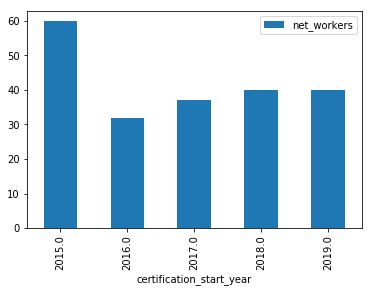

In [66]:
erie_crosstab.plot.bar()